In [34]:
from util import api_hook as ap
import nest_asyncio
nest_asyncio.apply()  # Allo
api_key="362de69bbf9e42f7b9e41b6563dee0a2"
api="https://newsapi.org/v2/everything?q=tesla&from=2025-02-09&sortBy=publishedAt&apiKey="

In [35]:
fetch =ap(output_path="fetched_data.json")
fetch.run(f"{api}{api_key}")

HTTP error occurred: 426, message='Upgrade Required', url='https://newsapi.org/v2/everything?q=tesla&from=2025-02-09&sortBy=publishedAt&apiKey=362de69bbf9e42f7b9e41b6563dee0a2'
Failed to fetch data.


# WORD

In [36]:
import json
import pandas as pd
from model import SkipGramModel
from util import createPairs
import nltk
import numpy as np
from tqdm import tqdm
import pickle
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import random
with open("fetched_data.json", "r") as file:
    json_data = json.load(file)
df = pd.json_normalize(json_data['articles'])
df.head(1)

,author,title,description,url,urlToImage,publishedAt,content,source.id,source.name
0,Frode Wikesjö,Årets STCC-säsong läggs på is,Siktar på comeback 2026\n\n\n\n\n\n\nDen klass...,https://feber.se/samhalle/arets-stcc-sasong-la...,https://static.feber.se/article_images/61/28/5...,2025-03-08T08:00:00Z,4 idag\r\nVälkommen till Feber\r\nSkaffa Feber...,None,Feber.se


In [37]:
df.drop(labels=['urlToImage','publishedAt','source.id','source.name','url','author'],axis=1,inplace=True)

In [38]:
pairs =  createPairs(df,drop=True)
vocab,word_pairs = pairs.get_vocab_and_pairs(column='title')

In [39]:
word_pairs,vocab

([('rep', 'gilbert'),
  ('gilbert', 'rep'),
  ('gilbert', 'ray'),
  ('ray', 'gilbert'),
  ('ray', 'cisneros'),
  ('cisneros', 'ray'),
  ('cisneros', 'jr'),
  ('jr', 'cisneros'),
  ('jr', 'purchases'),
  ('purchases', 'jr'),
  ('purchases', 'shares'),
  ('shares', 'purchases'),
  ('shares', 'tesla'),
  ('tesla', 'shares'),
  ('tesla', 'inc'),
  ('inc', 'tesla'),
  ('inc', 'nasdaqtsla'),
  ('nasdaqtsla', 'inc'),
  ('best', 'energy'),
  ('energy', 'best'),
  ('energy', 'stocks'),
  ('stocks', 'energy'),
  ('stocks', 'watch'),
  ('watch', 'stocks'),
  ('watch', 'today'),
  ('today', 'watch'),
  ('today', 'march'),
  ('march', 'today'),
  ('march', 'th'),
  ('th', 'march'),
  ('industrial', 'stocks'),
  ('stocks', 'industrial'),
  ('stocks', 'worth'),
  ('worth', 'stocks'),
  ('worth', 'watching'),
  ('watching', 'worth'),
  ('watching', 'march'),
  ('march', 'watching'),
  ('march', 'th'),
  ('th', 'march'),
  ('trump', 'tariff'),
  ('tariff', 'trump'),
  ('tariff', 'threat'),
  ('threat',

In [40]:
model =SkipGramModel(vocab_size=len(vocab),embedding_dim=300)

In [63]:
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def plot_embeddings_tsne(embeddings, words_to_plot=None, max_display=10):
    # Pilih embedding yang akan diplot
    if words_to_plot:
        selected_embeddings = {word: embeddings[word] for word in words_to_plot if word in embeddings}
    else:
        selected_embeddings = embeddings

    total_words = len(selected_embeddings)
    
    # Jika jumlah kata melebihi batas max_display, ambil sampel acak
    if total_words > max_display:
        sampled_items = random.sample(list(selected_embeddings.items()), max_display)
        selected_embeddings = dict(sampled_items)
        total_words = len(selected_embeddings)
    
    # Ambil daftar kata dan susun vektor embedding dalam array
    words = list(selected_embeddings.keys())
    vectors = np.array([selected_embeddings[word] for word in words])
    perplexity_value = min(30, total_words - 1)
    tsne = TSNE(n_components=2, perplexity=perplexity_value, random_state=42)
    reduced_vectors = tsne.fit_transform(vectors)
    plt.figure(figsize=(10, 10))
    plt.scatter(reduced_vectors[:, 0], reduced_vectors[:, 1], edgecolors='k', c='r')
    for i, word in enumerate(words):
        plt.annotate(word, (reduced_vectors[i, 0], reduced_vectors[i, 1]),
                     textcoords="offset points", xytext=(5, 2), ha="right", fontsize=9)
    plt.title(f'Visualisasi Word Embeddings dengan t-SNE (Menampilkan {len(words)}  kata)')
    plt.xlabel('Dimensi 1')
    plt.ylabel('Dimensi 2')
    plt.grid(True)
    plt.show()


    
def compute_cosine_similarity(embeddings):
    words = list(embeddings.keys())
    vectors = np.array([embeddings[word] for word in words])
    similarity_matrix = cosine_similarity(vectors)
    similarity_df = pd.DataFrame(similarity_matrix, index=words, columns=words)
    return similarity_df
def get_all_similarity_lists(similarity_df, word, top_n=5):

    if word not in similarity_df.columns:
        raise ValueError(f"Word '{word}' not found in similarity matrix.")
    similarities = similarity_df[word].drop(labels=[word])
    sorted_desc = similarities.sort_values(ascending=False)
    top_similar = sorted_desc.head(top_n)
    sorted_asc = similarities.sort_values(ascending=True)
    top_dissimilar = sorted_asc.head(top_n)
    negative_similarities = similarities[similarities < 0]
    if negative_similarities.empty:
        top_negative = []
    else:
        top_negative = negative_similarities.sort_values(ascending=True).head(top_n)
    return {
        "similar": list(zip(top_similar.index, top_similar.values)),
        "dissimilar": list(zip(top_dissimilar.index, top_dissimilar.values)),
        "negative": list(zip(top_negative.index, top_negative.values))
    }


def extract_embeddings(model, word2idx):
    embeddings = {}
    for word, idx in word2idx.items():
        embeddings[word] = model.W1[idx]
    return embeddings




In [42]:
def train(vocab, training_pairs, epochs, learning_rate=0.01):
    # Membuat kamus (dictionary) yang memetakan setiap kata ke indeks unik berdasarkan vocab
    word2idx = {word: idx for idx, word in enumerate(vocab)}
    # Membuat instance dari SkipGramModel dengan ukuran vocabulary dan dimensi embedding  "lookup table" 20 dimensi
    model = SkipGramModel(vocab_size=len(vocab), embedding_dim=20)  
    # Menyimpan history loss per epoch
    loss_history = []
    # Pastikan training_pairs berbentuk list agar dapat diiterasi dengan benar
    if not isinstance(training_pairs, list):
        training_pairs = list(training_pairs)
    # Mendapatkan total jumlah pasangan training
    total_pairs = len(training_pairs)
    # Melakukan iterasi untuk setiap epoch
    for epoch in range(1, epochs + 1):
        total_loss = 0  # Reset total loss pada awal setiap epoch
        
        # Menggunakan tqdm untuk menampilkan progress bar selama epoch
        with tqdm(total=total_pairs, desc=f"Epoch {epoch}/{epochs}", unit="pair") as pbar:
            # Iterasi setiap pasangan (target_word, context_word) pada training_pairs
            for i, (target_word, context_word) in enumerate(training_pairs, start=1):
                # Membuat one-hot encoding untuk kata target
                target_vector = np.zeros(len(vocab))  # Membuat vector dengan panjang sama dengan vocab
                target_vector[word2idx[target_word]] = 1  # Set indeks kata target menjadi 1
                # Membuat one-hot encoding untuk kata konteks
                context_vector = np.zeros(len(vocab))
                context_vector[word2idx[context_word]] = 1  # Set indeks kata konteks menjadi 1
                # Melakukan forward propagation melalui model dengan one-hot vector target
                hidden, output = model.forward(target_vector)
                # Menambahkan nilai kecil untuk menghindari log(0)
                epsilon = 1e-10 
                # Menghitung loss menggunakan negative log likelihood untuk probabilitas kata konteks
                loss = -np.log(output[word2idx[context_word]] + epsilon)
                # Melakukan backward propagation untuk update bobot model
                model.backward(target_vector, context_vector, learning_rate=learning_rate)
                # Menambahkan loss dari pasangan ini ke total loss epoch
                total_loss += loss
                # Update progress bar setiap 20 pasangan
                if i % 20 == 0:
                    pbar.update(20)  
                    pbar.set_postfix(loss=loss)
            # Jika total pasangan tidak habis dibagi 20, update sisa pasangan
            remainder = total_pairs % 20
            if remainder != 0:
                pbar.update(remainder)
                pbar.set_postfix(loss=loss)
        
        # Menghitung rata-rata loss per pasangan untuk epoch ini
        average_loss = total_loss / total_pairs
        loss_history.append(average_loss)
        print(f"Epoch {epoch}/{epochs}, Average Loss: {average_loss:.6f}")
    
    # Plot grafik training loss per epoch
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, epochs + 1), loss_history, marker='o')
    plt.title('Training Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Average Loss')
    plt.grid(True)
    plt.show()
    
    # Mengembalikan model yang telah dilatih beserta mapping word-to-index
    return model, word2idx


Epoch 1/100: 100%|██████████| 1032/1032 [00:00<00:00, 10158.23pair/s, loss=5.78]


Epoch 1/100, Average Loss: 5.780669


Epoch 2/100: 100%|██████████| 1032/1032 [00:00<00:00, 13194.86pair/s, loss=5.78]


Epoch 2/100, Average Loss: 5.779866


Epoch 3/100: 100%|██████████| 1032/1032 [00:00<00:00, 11238.04pair/s, loss=5.78]


Epoch 3/100, Average Loss: 5.772797


Epoch 4/100: 100%|██████████| 1032/1032 [00:00<00:00, 13450.38pair/s, loss=5.78]


Epoch 4/100, Average Loss: 5.694370


Epoch 5/100: 100%|██████████| 1032/1032 [00:00<00:00, 11940.16pair/s, loss=5.78]


Epoch 5/100, Average Loss: 5.457691


Epoch 6/100: 100%|██████████| 1032/1032 [00:00<00:00, 11394.38pair/s, loss=5.78]


Epoch 6/100, Average Loss: 5.253898


Epoch 7/100: 100%|██████████| 1032/1032 [00:00<00:00, 13768.61pair/s, loss=5.78]


Epoch 7/100, Average Loss: 5.022366


Epoch 8/100: 100%|██████████| 1032/1032 [00:00<00:00, 11347.34pair/s, loss=5.78]


Epoch 8/100, Average Loss: 4.759136


Epoch 9/100: 100%|██████████| 1032/1032 [00:00<00:00, 12966.56pair/s, loss=5.77]


Epoch 9/100, Average Loss: 4.511938


Epoch 10/100: 100%|██████████| 1032/1032 [00:00<00:00, 9654.64pair/s, loss=5.77] 


Epoch 10/100, Average Loss: 4.295631


Epoch 11/100: 100%|██████████| 1032/1032 [00:00<00:00, 11572.10pair/s, loss=5.76]


Epoch 11/100, Average Loss: 4.086470


Epoch 12/100: 100%|██████████| 1032/1032 [00:00<00:00, 10100.22pair/s, loss=5.76]


Epoch 12/100, Average Loss: 3.878201


Epoch 13/100: 100%|██████████| 1032/1032 [00:00<00:00, 13237.80pair/s, loss=5.75]


Epoch 13/100, Average Loss: 3.657198


Epoch 14/100: 100%|██████████| 1032/1032 [00:00<00:00, 11540.23pair/s, loss=5.74]


Epoch 14/100, Average Loss: 3.444718


Epoch 15/100: 100%|██████████| 1032/1032 [00:00<00:00, 12001.37pair/s, loss=5.73]


Epoch 15/100, Average Loss: 3.265745


Epoch 16/100: 100%|██████████| 1032/1032 [00:00<00:00, 9798.22pair/s, loss=5.71] 


Epoch 16/100, Average Loss: 3.120262


Epoch 17/100: 100%|██████████| 1032/1032 [00:00<00:00, 10949.88pair/s, loss=5.7] 


Epoch 17/100, Average Loss: 2.997871


Epoch 18/100: 100%|██████████| 1032/1032 [00:00<00:00, 11724.53pair/s, loss=5.67]


Epoch 18/100, Average Loss: 2.890222


Epoch 19/100: 100%|██████████| 1032/1032 [00:00<00:00, 13759.47pair/s, loss=5.65]


Epoch 19/100, Average Loss: 2.793076


Epoch 20/100: 100%|██████████| 1032/1032 [00:00<00:00, 11877.38pair/s, loss=5.61]


Epoch 20/100, Average Loss: 2.703394


Epoch 21/100: 100%|██████████| 1032/1032 [00:00<00:00, 12186.77pair/s, loss=5.56]


Epoch 21/100, Average Loss: 2.618968


Epoch 22/100: 100%|██████████| 1032/1032 [00:00<00:00, 11565.45pair/s, loss=5.5]  


Epoch 22/100, Average Loss: 2.538753


Epoch 23/100: 100%|██████████| 1032/1032 [00:00<00:00, 12756.01pair/s, loss=5.43] 


Epoch 23/100, Average Loss: 2.462056


Epoch 24/100: 100%|██████████| 1032/1032 [00:00<00:00, 11885.44pair/s, loss=5.33] 


Epoch 24/100, Average Loss: 2.387456


Epoch 25/100: 100%|██████████| 1032/1032 [00:00<00:00, 13796.09pair/s, loss=5.21] 


Epoch 25/100, Average Loss: 2.313502


Epoch 26/100: 100%|██████████| 1032/1032 [00:00<00:00, 11711.91pair/s, loss=5.05] 


Epoch 26/100, Average Loss: 2.239713


Epoch 27/100: 100%|██████████| 1032/1032 [00:00<00:00, 13209.40pair/s, loss=4.85] 


Epoch 27/100, Average Loss: 2.166659


Epoch 28/100: 100%|██████████| 1032/1032 [00:00<00:00, 11816.26pair/s, loss=4.59] 


Epoch 28/100, Average Loss: 2.095069


Epoch 29/100: 100%|██████████| 1032/1032 [00:00<00:00, 10423.12pair/s, loss=4.27] 


Epoch 29/100, Average Loss: 2.025856


Epoch 30/100: 100%|██████████| 1032/1032 [00:00<00:00, 12071.49pair/s, loss=3.87] 


Epoch 30/100, Average Loss: 1.961129


Epoch 31/100: 100%|██████████| 1032/1032 [00:00<00:00, 12357.25pair/s, loss=3.4]  


Epoch 31/100, Average Loss: 1.902917


Epoch 32/100: 100%|██████████| 1032/1032 [00:00<00:00, 10648.58pair/s, loss=2.88] 


Epoch 32/100, Average Loss: 1.852207


Epoch 33/100: 100%|██████████| 1032/1032 [00:00<00:00, 10849.59pair/s, loss=2.34] 


Epoch 33/100, Average Loss: 1.809663


Epoch 34/100: 100%|██████████| 1032/1032 [00:00<00:00, 11938.64pair/s, loss=1.85] 


Epoch 34/100, Average Loss: 1.775210


Epoch 35/100: 100%|██████████| 1032/1032 [00:00<00:00, 11648.62pair/s, loss=1.45] 


Epoch 35/100, Average Loss: 1.747758


Epoch 36/100: 100%|██████████| 1032/1032 [00:00<00:00, 13490.16pair/s, loss=1.15] 


Epoch 36/100, Average Loss: 1.725800


Epoch 37/100: 100%|██████████| 1032/1032 [00:00<00:00, 11510.31pair/s, loss=0.935]


Epoch 37/100, Average Loss: 1.708056


Epoch 38/100: 100%|██████████| 1032/1032 [00:00<00:00, 12427.14pair/s, loss=0.776]


Epoch 38/100, Average Loss: 1.693671


Epoch 39/100: 100%|██████████| 1032/1032 [00:00<00:00, 9611.35pair/s, loss=0.657] 


Epoch 39/100, Average Loss: 1.682087


Epoch 40/100: 100%|██████████| 1032/1032 [00:00<00:00, 11586.91pair/s, loss=0.566]


Epoch 40/100, Average Loss: 1.672865


Epoch 41/100: 100%|██████████| 1032/1032 [00:00<00:00, 11542.20pair/s, loss=0.493]


Epoch 41/100, Average Loss: 1.665623


Epoch 42/100: 100%|██████████| 1032/1032 [00:00<00:00, 12996.65pair/s, loss=0.435]


Epoch 42/100, Average Loss: 1.659972


Epoch 43/100: 100%|██████████| 1032/1032 [00:00<00:00, 11489.69pair/s, loss=0.386]


Epoch 43/100, Average Loss: 1.655581


Epoch 44/100: 100%|██████████| 1032/1032 [00:00<00:00, 13146.65pair/s, loss=0.346]


Epoch 44/100, Average Loss: 1.652139


Epoch 45/100: 100%|██████████| 1032/1032 [00:00<00:00, 11980.51pair/s, loss=0.312]


Epoch 45/100, Average Loss: 1.649445


Epoch 46/100: 100%|██████████| 1032/1032 [00:00<00:00, 13437.98pair/s, loss=0.284]


Epoch 46/100, Average Loss: 1.647389


Epoch 47/100: 100%|██████████| 1032/1032 [00:00<00:00, 10496.72pair/s, loss=0.259]


Epoch 47/100, Average Loss: 1.645866


Epoch 48/100: 100%|██████████| 1032/1032 [00:00<00:00, 12673.73pair/s, loss=0.238]


Epoch 48/100, Average Loss: 1.644775


Epoch 49/100: 100%|██████████| 1032/1032 [00:00<00:00, 10842.07pair/s, loss=0.22] 


Epoch 49/100, Average Loss: 1.644063


Epoch 50/100: 100%|██████████| 1032/1032 [00:00<00:00, 13511.85pair/s, loss=0.204]


Epoch 50/100, Average Loss: 1.643667


Epoch 51/100: 100%|██████████| 1032/1032 [00:00<00:00, 12297.95pair/s, loss=0.19] 


Epoch 51/100, Average Loss: 1.643525


Epoch 52/100: 100%|██████████| 1032/1032 [00:00<00:00, 11410.51pair/s, loss=0.177]


Epoch 52/100, Average Loss: 1.643590


Epoch 53/100: 100%|██████████| 1032/1032 [00:00<00:00, 11961.80pair/s, loss=0.167]


Epoch 53/100, Average Loss: 1.643841


Epoch 54/100: 100%|██████████| 1032/1032 [00:00<00:00, 12555.36pair/s, loss=0.157]


Epoch 54/100, Average Loss: 1.644216


Epoch 55/100: 100%|██████████| 1032/1032 [00:00<00:00, 12115.65pair/s, loss=0.148]


Epoch 55/100, Average Loss: 1.644633


Epoch 56/100: 100%|██████████| 1032/1032 [00:00<00:00, 11923.32pair/s, loss=0.14] 


Epoch 56/100, Average Loss: 1.645062


Epoch 57/100: 100%|██████████| 1032/1032 [00:00<00:00, 12890.45pair/s, loss=0.133]


Epoch 57/100, Average Loss: 1.645563


Epoch 58/100: 100%|██████████| 1032/1032 [00:00<00:00, 9633.75pair/s, loss=0.127]


Epoch 58/100, Average Loss: 1.646161


Epoch 59/100: 100%|██████████| 1032/1032 [00:00<00:00, 12521.90pair/s, loss=0.121]


Epoch 59/100, Average Loss: 1.646813


Epoch 60/100: 100%|██████████| 1032/1032 [00:00<00:00, 10060.88pair/s, loss=0.116]


Epoch 60/100, Average Loss: 1.647483


Epoch 61/100: 100%|██████████| 1032/1032 [00:00<00:00, 12691.71pair/s, loss=0.111]


Epoch 61/100, Average Loss: 1.648187


Epoch 62/100: 100%|██████████| 1032/1032 [00:00<00:00, 12104.06pair/s, loss=0.106]


Epoch 62/100, Average Loss: 1.648945


Epoch 63/100: 100%|██████████| 1032/1032 [00:00<00:00, 10046.07pair/s, loss=0.102]


Epoch 63/100, Average Loss: 1.649778


Epoch 64/100: 100%|██████████| 1032/1032 [00:00<00:00, 13109.78pair/s, loss=0.0982]


Epoch 64/100, Average Loss: 1.650686


Epoch 65/100: 100%|██████████| 1032/1032 [00:00<00:00, 12281.27pair/s, loss=0.0947]


Epoch 65/100, Average Loss: 1.651698


Epoch 66/100: 100%|██████████| 1032/1032 [00:00<00:00, 13650.98pair/s, loss=0.0915]


Epoch 66/100, Average Loss: 1.652834


Epoch 67/100: 100%|██████████| 1032/1032 [00:00<00:00, 11654.77pair/s, loss=0.0884]


Epoch 67/100, Average Loss: 1.654100


Epoch 68/100: 100%|██████████| 1032/1032 [00:00<00:00, 13064.71pair/s, loss=0.0856]


Epoch 68/100, Average Loss: 1.655490


Epoch 69/100: 100%|██████████| 1032/1032 [00:00<00:00, 12109.92pair/s, loss=0.083]


Epoch 69/100, Average Loss: 1.656983


Epoch 70/100: 100%|██████████| 1032/1032 [00:00<00:00, 11259.14pair/s, loss=0.0806]


Epoch 70/100, Average Loss: 1.658581


Epoch 71/100: 100%|██████████| 1032/1032 [00:00<00:00, 11696.34pair/s, loss=0.0783]


Epoch 71/100, Average Loss: 1.660294


Epoch 72/100: 100%|██████████| 1032/1032 [00:00<00:00, 11192.45pair/s, loss=0.0762]


Epoch 72/100, Average Loss: 1.662129


Epoch 73/100: 100%|██████████| 1032/1032 [00:00<00:00, 12015.66pair/s, loss=0.0742]


Epoch 73/100, Average Loss: 1.664118


Epoch 74/100: 100%|██████████| 1032/1032 [00:00<00:00, 10808.23pair/s, loss=0.0723]


Epoch 74/100, Average Loss: 1.666228


Epoch 75/100: 100%|██████████| 1032/1032 [00:00<00:00, 11440.92pair/s, loss=0.0706]


Epoch 75/100, Average Loss: 1.668406


Epoch 76/100: 100%|██████████| 1032/1032 [00:00<00:00, 12558.31pair/s, loss=0.0689]


Epoch 76/100, Average Loss: 1.670654


Epoch 77/100: 100%|██████████| 1032/1032 [00:00<00:00, 12533.00pair/s, loss=0.0674]


Epoch 77/100, Average Loss: 1.672967


Epoch 78/100: 100%|██████████| 1032/1032 [00:00<00:00, 10924.98pair/s, loss=0.0659]


Epoch 78/100, Average Loss: 1.675312


Epoch 79/100: 100%|██████████| 1032/1032 [00:00<00:00, 12093.55pair/s, loss=0.0646]


Epoch 79/100, Average Loss: 1.677610


Epoch 80/100: 100%|██████████| 1032/1032 [00:00<00:00, 11284.86pair/s, loss=0.0632]


Epoch 80/100, Average Loss: 1.679797


Epoch 81/100: 100%|██████████| 1032/1032 [00:00<00:00, 12536.48pair/s, loss=0.062]


Epoch 81/100, Average Loss: 1.681859


Epoch 82/100: 100%|██████████| 1032/1032 [00:00<00:00, 10783.86pair/s, loss=0.0608]


Epoch 82/100, Average Loss: 1.683776


Epoch 83/100: 100%|██████████| 1032/1032 [00:00<00:00, 9823.97pair/s, loss=0.0596]


Epoch 83/100, Average Loss: 1.685529


Epoch 84/100: 100%|██████████| 1032/1032 [00:00<00:00, 12205.67pair/s, loss=0.0585]


Epoch 84/100, Average Loss: 1.687121


Epoch 85/100: 100%|██████████| 1032/1032 [00:00<00:00, 12259.11pair/s, loss=0.0574]


Epoch 85/100, Average Loss: 1.688535


Epoch 86/100: 100%|██████████| 1032/1032 [00:00<00:00, 10121.05pair/s, loss=0.0564]


Epoch 86/100, Average Loss: 1.689774


Epoch 87/100: 100%|██████████| 1032/1032 [00:00<00:00, 11883.48pair/s, loss=0.0554]


Epoch 87/100, Average Loss: 1.690835


Epoch 88/100: 100%|██████████| 1032/1032 [00:00<00:00, 10423.72pair/s, loss=0.0544]


Epoch 88/100, Average Loss: 1.691789


Epoch 89/100: 100%|██████████| 1032/1032 [00:00<00:00, 10891.06pair/s, loss=0.0534]


Epoch 89/100, Average Loss: 1.692658


Epoch 90/100: 100%|██████████| 1032/1032 [00:00<00:00, 10097.73pair/s, loss=0.0525]


Epoch 90/100, Average Loss: 1.693541


Epoch 91/100: 100%|██████████| 1032/1032 [00:00<00:00, 12177.24pair/s, loss=0.0516]


Epoch 91/100, Average Loss: 1.694467


Epoch 92/100: 100%|██████████| 1032/1032 [00:00<00:00, 9595.78pair/s, loss=0.0507]


Epoch 92/100, Average Loss: 1.695438


Epoch 93/100: 100%|██████████| 1032/1032 [00:00<00:00, 11415.66pair/s, loss=0.0499]


Epoch 93/100, Average Loss: 1.696472


Epoch 94/100: 100%|██████████| 1032/1032 [00:00<00:00, 11091.27pair/s, loss=0.049]


Epoch 94/100, Average Loss: 1.697508


Epoch 95/100: 100%|██████████| 1032/1032 [00:00<00:00, 12053.94pair/s, loss=0.0482]


Epoch 95/100, Average Loss: 1.698515


Epoch 96/100: 100%|██████████| 1032/1032 [00:00<00:00, 11239.53pair/s, loss=0.0474]


Epoch 96/100, Average Loss: 1.699477


Epoch 97/100: 100%|██████████| 1032/1032 [00:00<00:00, 12500.93pair/s, loss=0.0467]


Epoch 97/100, Average Loss: 1.700389


Epoch 98/100: 100%|██████████| 1032/1032 [00:00<00:00, 12964.42pair/s, loss=0.046]


Epoch 98/100, Average Loss: 1.701269


Epoch 99/100: 100%|██████████| 1032/1032 [00:00<00:00, 10350.07pair/s, loss=0.0453]


Epoch 99/100, Average Loss: 1.702121


Epoch 100/100: 100%|██████████| 1032/1032 [00:00<00:00, 11690.62pair/s, loss=0.0446]


Epoch 100/100, Average Loss: 1.702965


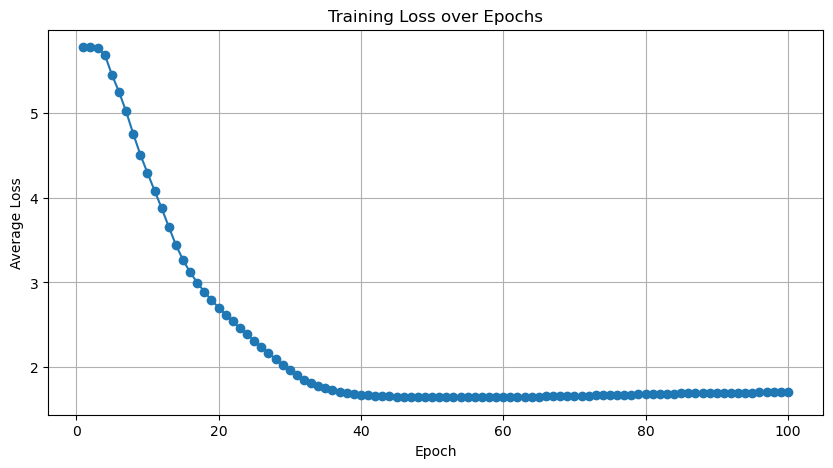

In [43]:
model,word2idx=train(vocab=vocab,training_pairs=word_pairs,epochs=100,learning_rate=0.1)

In [44]:
import pickle
embeddings = extract_embeddings(model, word2idx)
with open('word_embeddings.pkl', 'wb') as f:
    pickle.dump(embeddings, f)
with open('skipgram_model.pkl', 'wb') as f:
    pickle.dump(model, f)

In [ ]:
# Asumsikan Anda sudah memiliki similarity_df dari fungsi compute_cosine_similarity
similarity_df = compute_cosine_similarity(embeddings)

word = 'musk'
top_n = 5

# Panggil fungsi untuk mendapatkan semua daftar
results = get_all_similarity_lists(similarity_df, word, top_n=top_n)

print(f"Top {top_n} kata paling mirip dengan '{word}':")
for similar_word, score in results["similar"]:
    print(f"  {similar_word}: {score:.4f}")

print(f"\nTop {top_n} kata paling tidak mirip (orthogonal) dengan '{word}':")
for dissimilar_word, score in results["dissimilar"]:
    print(f"  {dissimilar_word}: {score:.4f}")

print(f"\nTop {top_n} kata dengan similarity negatif terhadap '{word}':")
if results["negative"]:
    for neg_word, score in results["negative"]:
        print(f"  {neg_word}: {score:.4f}")
else:
    print("  Tidak ada kata dengan nilai similarity negatif.")



Top 5 kata paling mirip dengan 'musk':
  protests: 0.8066
  spacex: 0.7682
  clash: 0.7167
  musks: 0.6262
  reining: 0.5845

Top 5 kata paling tidak mirip (orthogonal) dengan 'musk':
  across: -0.5895
  found: -0.5250
  cheapest: -0.4982
  iql: -0.4901
  enel: -0.4696

Top 5 kata dengan similarity negatif terhadap 'musk':
  across: -0.5895
  found: -0.5250
  cheapest: -0.4982
  iql: -0.4901
  enel: -0.4696


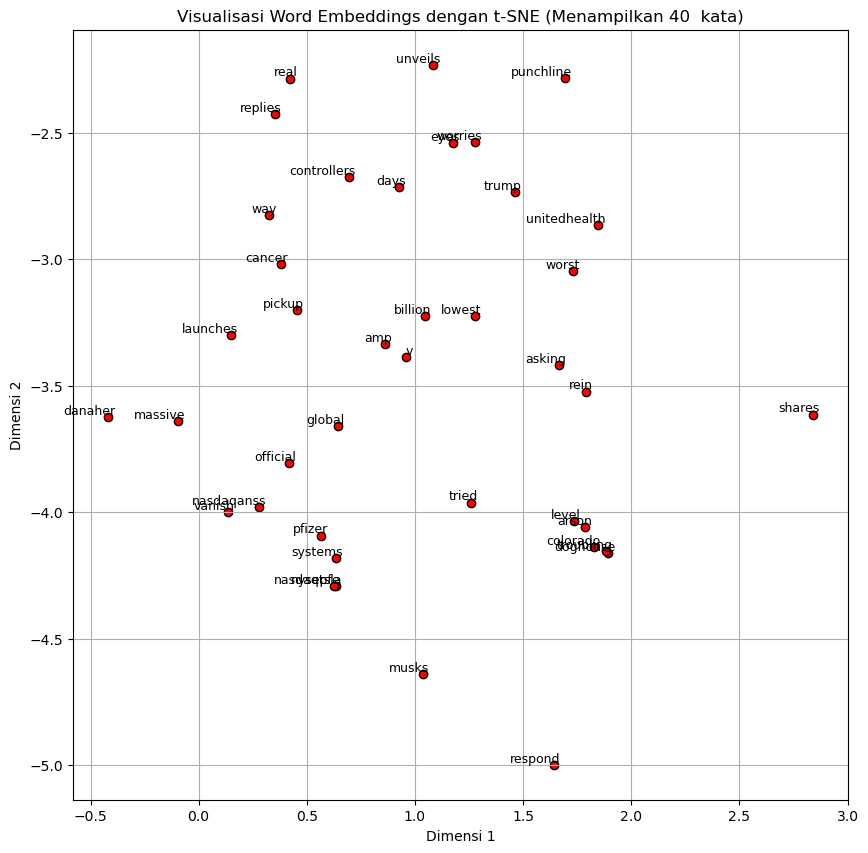

In [66]:
plot_embeddings_tsne(embeddings,max_display=40)